# Step 2 - Aggregations
## Goals in this Notebook
- Iteratively explore the different tables with the goal of generating aggregated features into the application table to predict the TARGET feature.
- Create functions to perform these aggregations.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils.functions as functions

## Load in Data

In [2]:
df_app = pd.read_parquet(r"data\train\df_app.parquet", engine="pyarrow")
df_bur = pd.read_parquet(r"data\train\df_bur.parquet", engine="pyarrow")
df_bur_bal = pd.read_parquet(r"data\train\df_bur_bal.parquet", engine="pyarrow")
df_prev_app = pd.read_parquet(r"data\train\df_prev_app.parquet", engine="pyarrow")
df_cash = pd.read_parquet(r"data\train\df_cash.parquet", engine="pyarrow")
df_inst = pd.read_parquet(r"data\train\df_inst.parquet", engine="pyarrow")
df_cred = pd.read_parquet(r"data\train\df_cred.parquet", engine="pyarrow")

Check if IDs are populated everywhere.

In [3]:
curr_dfs = [df_app, df_bur, df_prev_app, df_cash, df_inst, df_cred]
bur_dfs = [df_bur, df_bur_bal]
prev_dfs = [df_prev_app, df_cash, df_inst, df_cred]

for df in curr_dfs:
    functions.check_df_nulls(df["SK_ID_CURR"])

for df in bur_dfs:
    functions.check_df_nulls(df["SK_ID_BUREAU"])

for df in prev_dfs:
    functions.check_df_nulls(df["SK_ID_PREV"])

All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok


## Aggregating Bureau Balance Table

In [4]:
df_bur_bal.shape

(13966128, 3)

Just 3 columns, but a lot of rows.

In [5]:
df_bur_bal.sample(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
11119852,5023550,-1,C
1596234,5242786,-13,C
13483399,6233483,-10,C
5076080,5205620,-56,C
12962242,6051167,-22,C


MONTHS_BALANCE - time measure. STATUS - missing data, closed, no days past due (DPD) or some DPD.

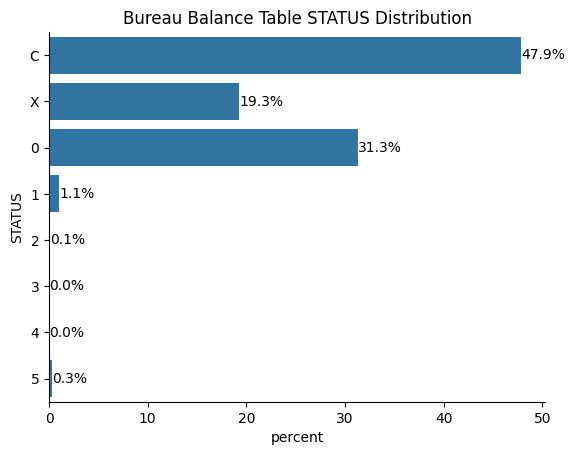

In [6]:
df_bur_bal_sample = df_bur_bal.sample(frac=0.05, random_state=42)
sns.countplot(
    df_bur_bal_sample["STATUS"],
    stat="percent",
    order=["C", "X", "0", "1", "2", "3", "4", "5"],
)
plt.title("Bureau Balance Table STATUS Distribution")
functions.add_labels(fmt="%1.1f%%")
sns.despine()

Just a few statuses captured DPD. For this table's aggregations, I chose to calculate last and max status of a loan, as well as the mean and std when it was not closed yet.

Here's an example how it would look for one of the current customers:

In [7]:
curr_ids = [334358]

df_bur_filtered = df_bur[df_bur["SK_ID_CURR"].isin(curr_ids)]
bureau_ids = df_bur_filtered["SK_ID_BUREAU"]

df_bur_bal_filtered = df_bur_bal[df_bur_bal["SK_ID_BUREAU"].isin(bureau_ids)]

functions.aggregate_bur_bal(df_bur_bal_filtered)

,SK_ID_BUREAU,STATUS_last,STATUS_mean,STATUS_std,STATUS_max
0,5501454,-1.0,0.000000,0.000000,0.0
1,5501456,-1.0,0.000000,0.000000,0.0
2,5501455,NaN,0.153846,0.375534,1.0


### Explore Bureau Balance Aggregations

In [8]:
df_bur_bal_agg = functions.aggregate_bur_bal(df_bur_bal)

Null proportions for the feature:


STATUS_last
False    0.539916
True     0.460084
Name: proportion, dtype: float64

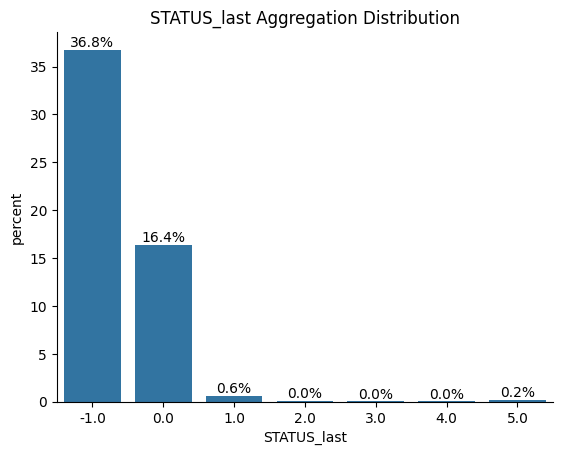

In [9]:
sns.countplot(df_bur_bal_agg, x="STATUS_last", stat="percent")
plt.title("STATUS_last Aggregation Distribution")
functions.add_labels(fmt="%.1f%%")
sns.despine()
print("Null proportions for the feature:")


df_bur_bal_agg["STATUS_last"].isna().value_counts(normalize=True)

46% of applications lacked a value for where the last status - where MONTHS_BALANCE is 0. Around 1% of those that have a last status are past due. **Looking back on this after a month**, I should have used the biggest value of MONTHS_BALANCE rather than using 0. This could have decreased the null proportion and perhaps made a more informative feature.

Null proportions for the feature:


STATUS_mean
False    0.875462
True     0.124538
Name: proportion, dtype: float64

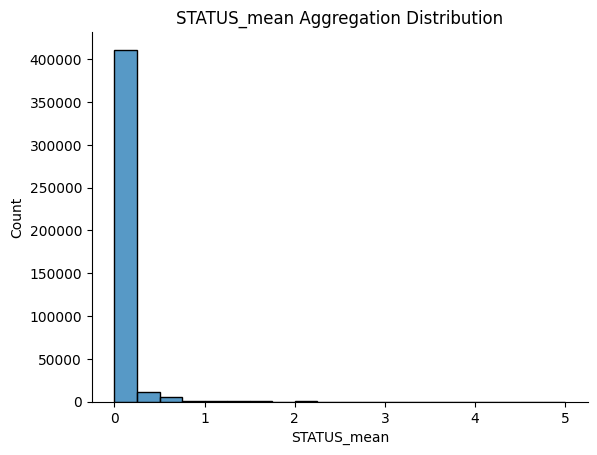

In [10]:
sns.histplot(df_bur_bal_agg, x="STATUS_mean")
plt.title("STATUS_mean Aggregation Distribution")
sns.despine()
print("Null proportions for the feature:")
df_bur_bal_agg["STATUS_mean"].isna().value_counts(normalize=True)

The mean of STATUS has a better null proportion and most loans have it at around 0.

## Aggregating Bureau Table

First, merge Bureau balance aggregations onto Bureau table

In [11]:
df = df_bur.merge(df_bur_bal_agg, how="outer", on="SK_ID_BUREAU")

### Explore the Table's Features

In [12]:
df_filtered = df[df["SK_ID_CURR"].isin(curr_ids)]
df_filtered.iloc[:, :8]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT
604825,334358,5501454,Closed,currency 1,-1696,0,-1359.0,-1359.0
604826,334358,5501455,Closed,currency 1,-2509,0,-2204.0,-2201.0
604827,334358,5501456,Closed,currency 1,-342,0,-69.0,-69.0


In [13]:
df_filtered.iloc[:, 8:14]

,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
604825,NaN,0,131706.0,0.0,0.0,0.0
604826,0.0,0,41067.0,NaN,NaN,0.0
604827,0.0,0,99000.0,0.0,0.0,0.0


In [14]:
df_filtered.iloc[:, 14:]

,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,STATUS_last,STATUS_mean,STATUS_std,STATUS_max
604825,Consumer credit,-1357,NaN,-1.0,0.000000,0.000000,0.0
604826,Consumer credit,-2197,30055.5,NaN,0.153846,0.375534,1.0
604827,Consumer credit,-67,NaN,-1.0,0.000000,0.000000,0.0


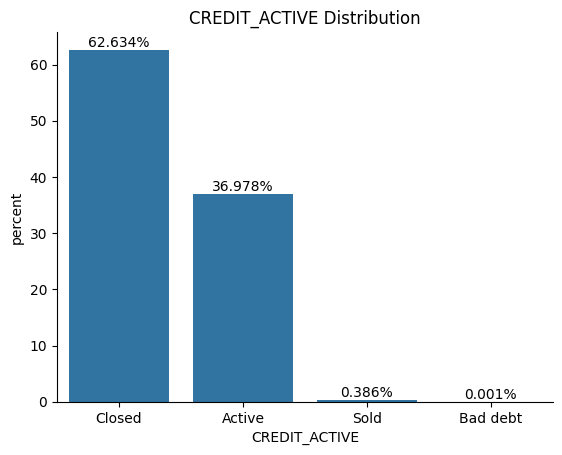

In [15]:
sns.countplot(df.fillna("NONE"), x="CREDIT_ACTIVE", stat="percent")
functions.add_labels(fmt="%2.3f%%")
plt.title("CREDIT_ACTIVE Distribution")
sns.despine()

This should provide the same info as our aggregate STATUS_last. It provides additional info and also we seem to be lacking the aggregate quite frequently. We could consider dropping our STATUS_last aggregate and use this instead. To aggregate CREDIT_ACTIVE, we would probably want to have the counts of categories.

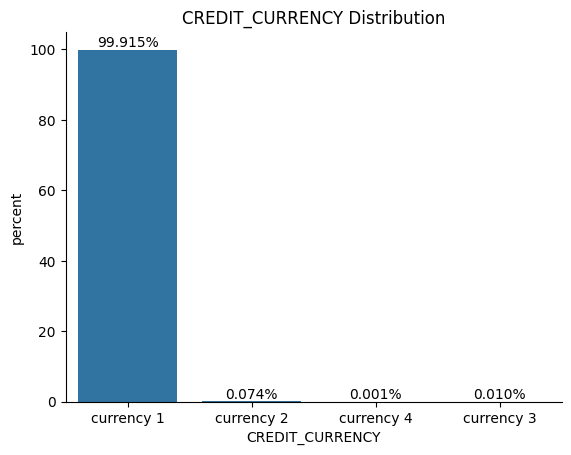

In [16]:
sns.countplot(df.fillna("NONE"), x="CREDIT_CURRENCY", stat="percent")
functions.add_labels(fmt="%2.3f%%")
plt.title("CREDIT_CURRENCY Distribution")
sns.despine()

Almost everyone is using currency 1, may only consider binary "uses other currencies". We'll use unique count to estimate this.

DAYS_CREDIT
False    1.0
Name: proportion, dtype: float64

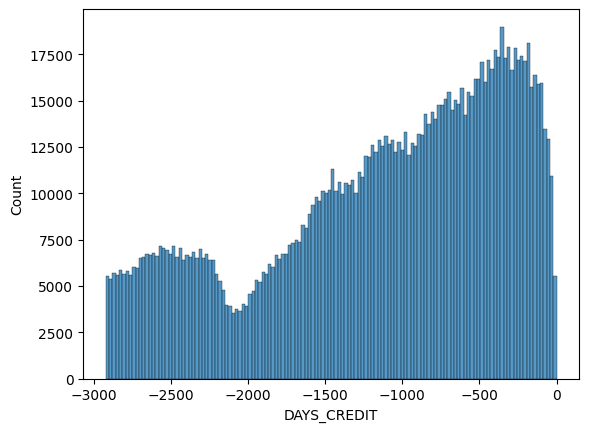

In [17]:
sns.histplot(df["DAYS_CREDIT"])
df["DAYS_CREDIT"].isna().value_counts(normalize=True)

The feature encodes the time when the status was take relative to current time. In the figure we encounter the interesting fact that all time in the dataset is negative. The smaller the number, the more in the past we go. For this particular feature's aggregations I took min and mean.

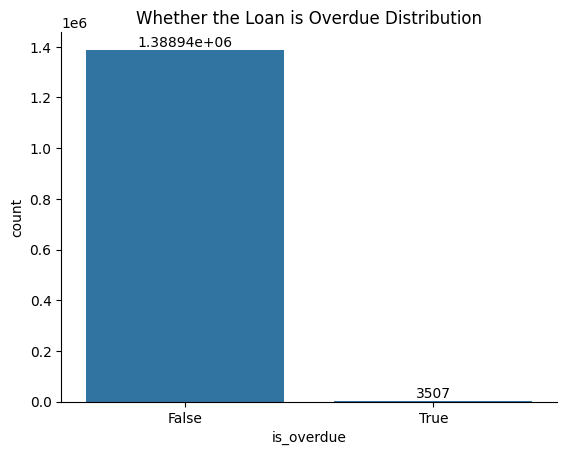

In [18]:
df_overdue = df[["CREDIT_DAY_OVERDUE"]].copy()
df_overdue["is_overdue"] = df_overdue["CREDIT_DAY_OVERDUE"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue")
functions.add_labels()
plt.title("Whether the Loan is Overdue Distribution")
sns.despine()

Very little loans seem to be overdue. Lets aggregate this column into "has_overdue"

Null proportions for the feature:


DAYS_CREDIT_ENDDATE
False    0.939135
True     0.060865
Name: proportion, dtype: float64

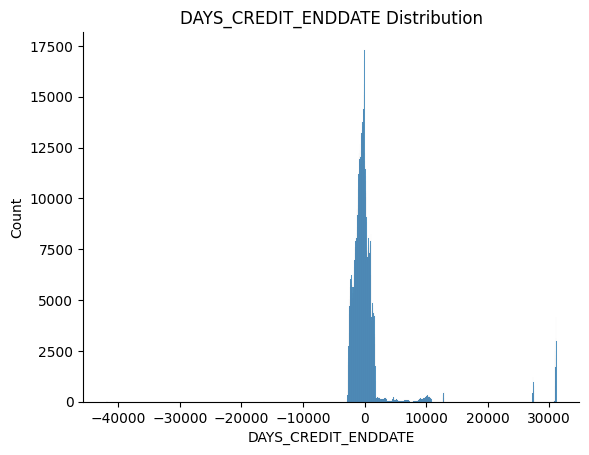

In [19]:
sns.histplot(df["DAYS_CREDIT_ENDDATE"])
plt.title("DAYS_CREDIT_ENDDATE Distribution")
sns.despine()
print("Null proportions for the feature:")


df["DAYS_CREDIT_ENDDATE"].isna().value_counts(normalize=True)

For those loans that are not closed, I'll calculate max and mean of this feature.

Null proportions for the feature:


DAYS_ENDDATE_FACT
False    0.628328
True     0.371672
Name: proportion, dtype: float64

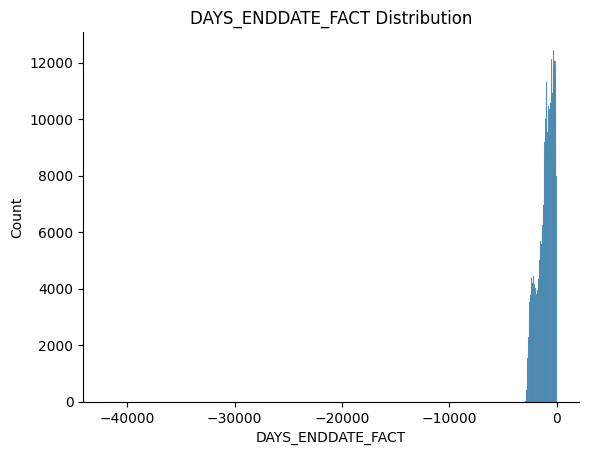

In [20]:
sns.histplot(df["DAYS_ENDDATE_FACT"])
plt.title("DAYS_ENDDATE_FACT Distribution")
sns.despine()
print("Null proportions for the feature:")


df["DAYS_ENDDATE_FACT"].isna().value_counts(normalize=True)

Quite a lot nulls and seems to overlap other feature - will not be used in aggregations.

Null proportions for the feature:


AMT_CREDIT_MAX_OVERDUE
True     0.647498
False    0.352502
Name: proportion, dtype: float64

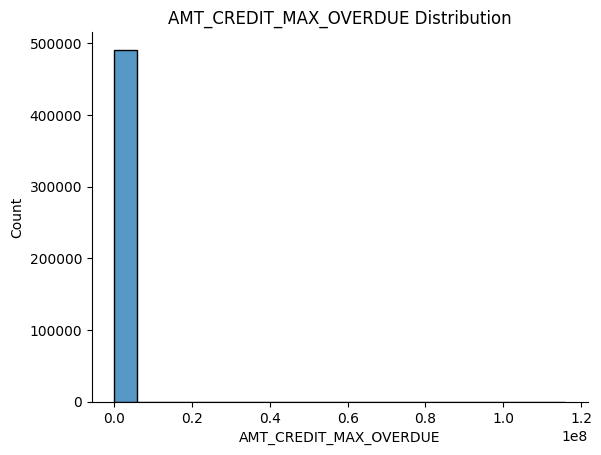

In [21]:
sns.histplot(df["AMT_CREDIT_MAX_OVERDUE"])
plt.title("AMT_CREDIT_MAX_OVERDUE Distribution")
sns.despine()
print("Null proportions for the feature:")


df["AMT_CREDIT_MAX_OVERDUE"].isna().value_counts(normalize=True)

The same as with the last feature.

Null proportions for the feature:


CNT_CREDIT_PROLONG
False    1.0
Name: proportion, dtype: float64

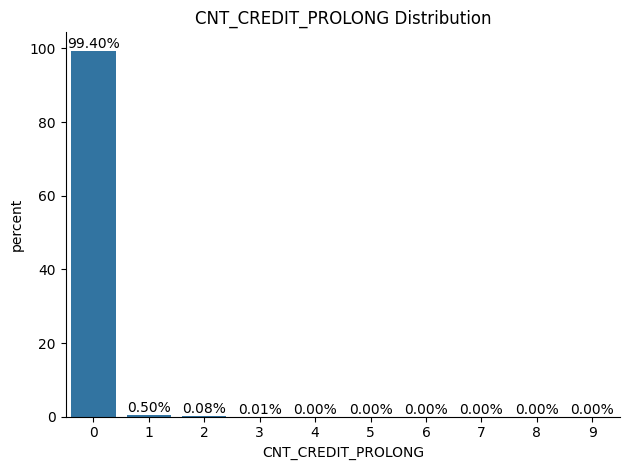

In [22]:
sns.countplot(df, x="CNT_CREDIT_PROLONG", stat="percent")
plt.title("CNT_CREDIT_PROLONG Distribution")
functions.add_labels(fmt="%2.2f%%")
plt.tight_layout()
sns.despine()
print("Null proportions for the feature:")


df["CNT_CREDIT_PROLONG"].isna().value_counts(normalize=True)

I'll aggregate into binary "has_prolonged".

All remaining AMT columns to be aggregated into max and mean: 
- AMT_CREDIT_SUM,
- AMT_CREDIT_SUM_DEBT,
- AMT_CREDIT_SUM_LIMIT,
- AMT_CREDIT_SUM_OVERDUE.

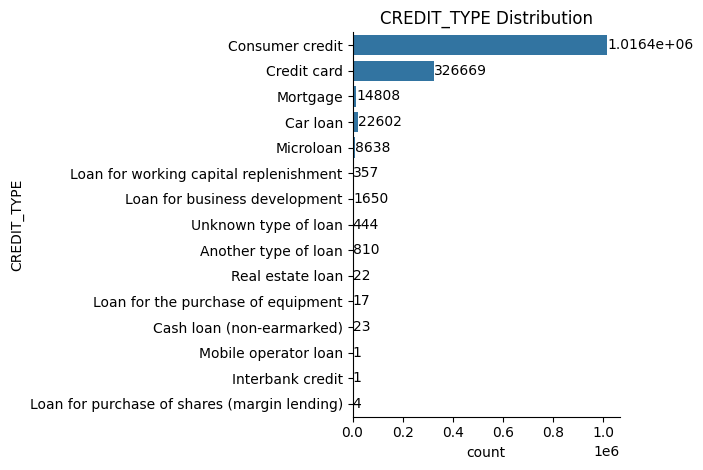

In [23]:
sns.countplot(df.fillna("None"), y="CREDIT_TYPE")
plt.title("CREDIT_TYPE Distribution")
sns.despine()
plt.tight_layout()
functions.add_labels()

Aggregate count of unique types, bin into 7 categories and count for each.

Null proportions for the feature:


DAYS_CREDIT_UPDATE
False    1.0
Name: proportion, dtype: float64

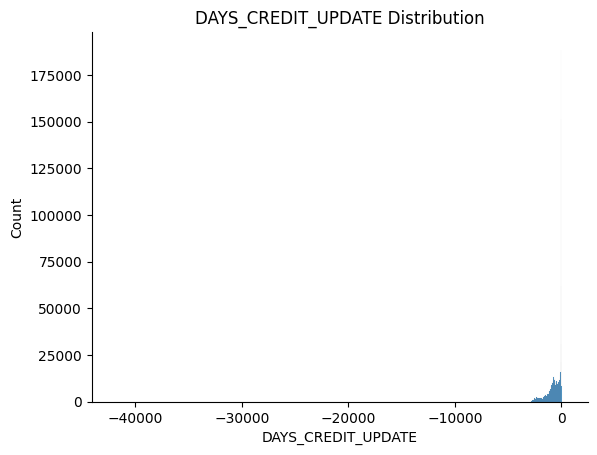

In [24]:
sns.histplot(df["DAYS_CREDIT_UPDATE"])
plt.title("DAYS_CREDIT_UPDATE Distribution")
sns.despine()
print("Null proportions for the feature:")


df["DAYS_CREDIT_UPDATE"].isna().value_counts(normalize=True)

As I don't see how this feature could help, I decided to drop.

Null proportions for the feature:


STATUS_last
True     0.807917
False    0.192083
Name: proportion, dtype: float64

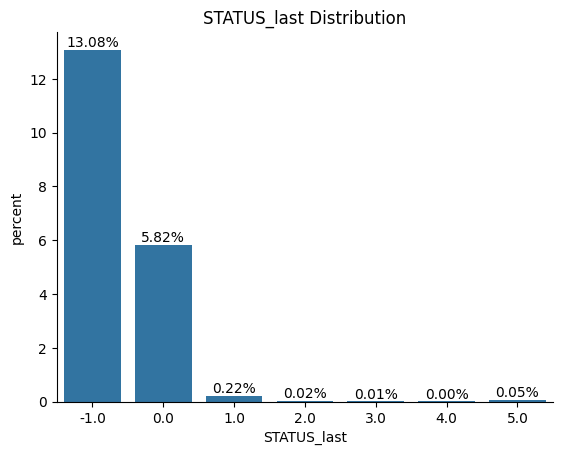

In [25]:
sns.countplot(df, x="STATUS_last", stat="percent")
plt.title("STATUS_last Distribution")
functions.add_labels(fmt="%2.2f%%")
sns.despine()
print("Null proportions for the feature:")


df["STATUS_last"].isna().value_counts(normalize=True)

Most are nan and mostly covered by other columns either way, so drop.

Null proportions for the feature:


STATUS_mean
True     0.688542
False    0.311458
Name: proportion, dtype: float64

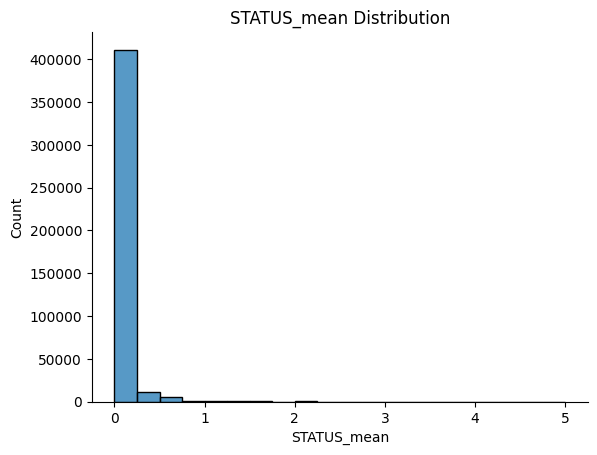

In [26]:
sns.histplot(df, x="STATUS_mean")
plt.title("STATUS_mean Distribution")
sns.despine()
print("Null proportions for the feature:")


df["STATUS_mean"].isna().value_counts(normalize=True)

Null proportions for the feature:


STATUS_std
True     0.706226
False    0.293774
Name: proportion, dtype: float64

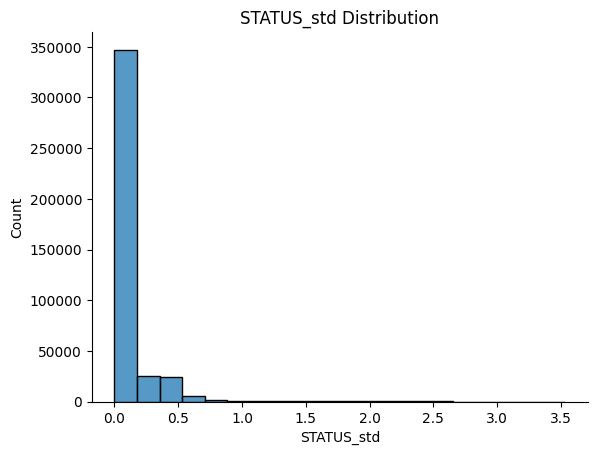

In [27]:
sns.histplot(df, x="STATUS_std")
plt.title("STATUS_std Distribution")
sns.despine()
print("Null proportions for the feature:")


df["STATUS_std"].isna().value_counts(normalize=True)

Null proportions for the feature:


STATUS_max
True     0.688542
False    0.311458
Name: proportion, dtype: float64

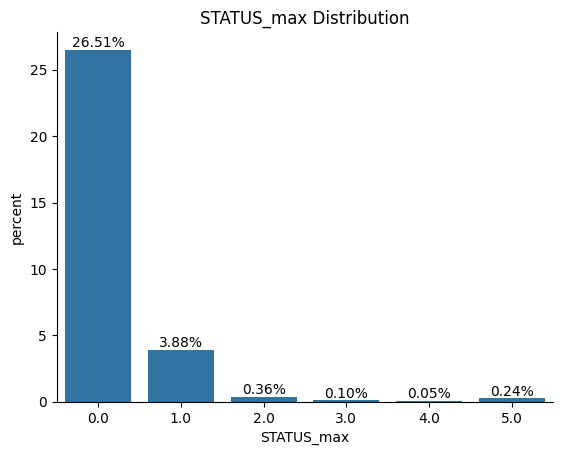

In [28]:
sns.countplot(df, x="STATUS_max", stat="percent")
plt.title("STATUS_max Distribution")
functions.add_labels(fmt="%2.2f%%")
sns.despine()
print("Null proportions for the feature:")


df["STATUS_max"].isna().value_counts(normalize=True)

After merging bureau balance aggregations with the main bureau table, we can see that the proportion of missing values increased dramatically. They may no longer be usable due to the amount of missing values, but we'll see later. For max let's aggregate a max, for std and mean - means.

### Aggregate the Table

In [29]:
aggregates_bur = functions.aggregate_bur(df)

In [30]:
# aggregates_bur.to_parquet("data/train/aggregates_bur.parquet")

### Add "Latest" Aggregations

Let's also create some aggregations for the latest statuses. From our assumption, we take only the last year here.

In [31]:
df_bur_latest = df[df["DAYS_CREDIT"] >= -365]
aggregates_latest_bur = df_bur_latest.groupby("SK_ID_CURR").agg(
    {
        "DAYS_CREDIT": ["count"],
        "CREDIT_DAY_OVERDUE": ["mean"],
        "AMT_CREDIT_MAX_OVERDUE": ["mean"],
        "CNT_CREDIT_PROLONG": ["mean"],
        "AMT_CREDIT_SUM": ["mean"],
        "AMT_CREDIT_SUM_DEBT": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
    }
)

aggregates_latest_bur.columns = aggregates_latest_bur.columns.map(
    "bur_lat_{0[0]}".format
)
# aggregates_latest_bur.to_parquet("data/train/aggregates_latest_bur.parquet")

## Aggregating df_cash

### Explore the Table

To handle the df_cash, df_inst, df_cred tables I will take the approach to aggregate by SK_ID_CURR rather than SK_ID_PREV as it skips an aggregation step.

In [32]:
df_cash.sample(5, random_state=42)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9163470,1877177,400440,-44,24.0,13.0,Active,0,0
2509391,1281422,127703,-50,18.0,16.0,Active,0,0
6778150,2643602,340852,-44,12.0,3.0,Active,0,0
5336954,2303866,390580,-8,12.0,9.0,Active,0,0
5025637,1584663,374481,-86,24.0,21.0,Active,0,0


In [33]:
curr_ids = df_app["SK_ID_CURR"]
df_cash[df_cash["SK_ID_CURR"] == curr_ids[3]].sort_values(
    ["SK_ID_PREV", "MONTHS_BALANCE"], ascending=False
)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9595258,2299329,100006,-13,5.0,0.0,Completed,0,0
1547042,2299329,100006,-14,5.0,0.0,Active,0,0
7813685,2299329,100006,-15,12.0,8.0,Active,0,0
3226333,2299329,100006,-16,12.0,9.0,Active,0,0
6415578,2299329,100006,-17,12.0,10.0,Active,0,0
1632814,2299329,100006,-18,12.0,11.0,Active,0,0
2084324,2299329,100006,-19,12.0,12.0,Active,0,0
2692043,2299329,100006,-20,NaN,NaN,Returned to the store,0,0
6935403,2190416,100006,-1,12.0,3.0,Active,0,0
9549306,2190416,100006,-2,12.0,4.0,Active,0,0


Above we have all the loans of one applicant. We can see that this example has no overdue cash loans, and only one loan is currently active.

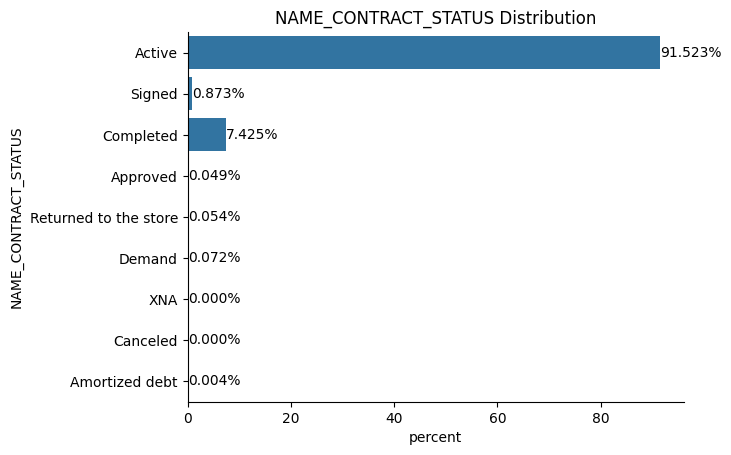

In [34]:
sns.countplot(df_cash.fillna("Value Missing"), y="NAME_CONTRACT_STATUS", stat="percent")
functions.add_labels(fmt="%2.3f%%")
plt.title("NAME_CONTRACT_STATUS Distribution")
sns.despine()

The majority of statuses are about active or completed loans. For aggregations I decided to count currently active loans.

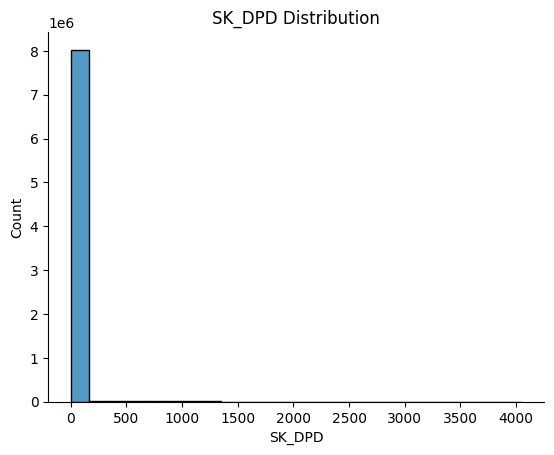

In [35]:
sns.histplot(df_cash["SK_DPD"])
plt.title("SK_DPD Distribution")
sns.despine()

Most loans had around zero DPD. There were some that had a lot of days past due.

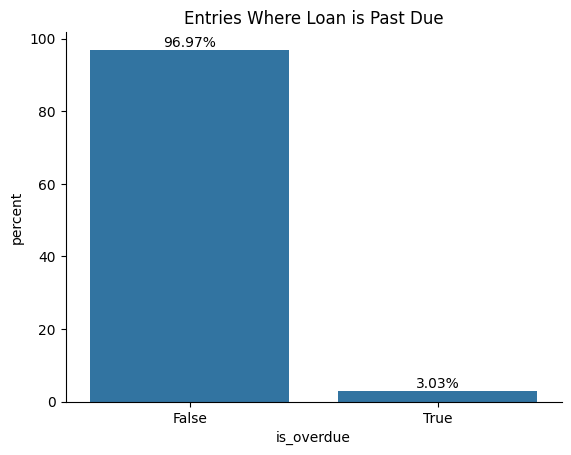

In [36]:
df_overdue = df_cash[["SK_DPD", "SK_DPD_DEF"]].copy()
df_overdue["is_overdue"] = df_overdue["SK_DPD"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue", stat="percent")
functions.add_labels(fmt="%2.2f%%")
plt.title("Entries Where Loan is Past Due")
sns.despine()

3% of entries have some overdue, which is not a lot. In aggregations I will try capturing the count of loans that have had a delinquency.

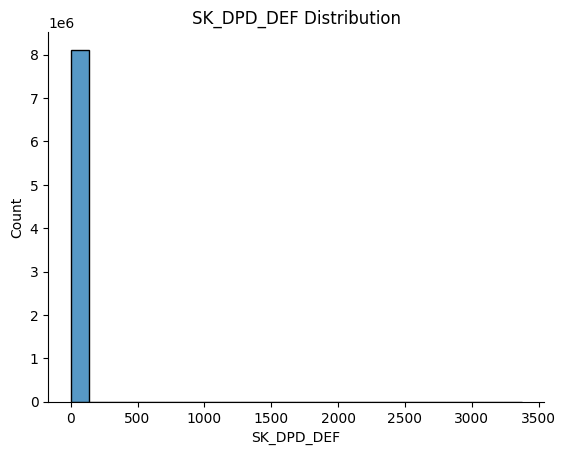

In [37]:
sns.histplot(df_cash["SK_DPD_DEF"])
plt.title("SK_DPD_DEF Distribution")
sns.despine()

Very similar to regular SK_DPD, but the tolerance in SK_DPD_DEF curbs the delinquant loans heavily.

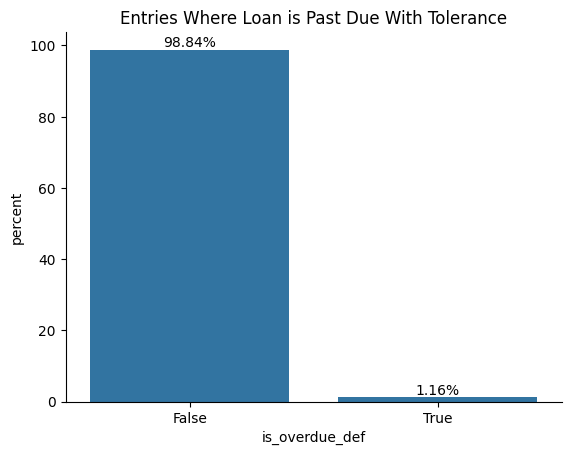

In [38]:
df_overdue["is_overdue_def"] = df_overdue["SK_DPD_DEF"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue_def", stat="percent")
functions.add_labels(fmt="%2.2f%%")
plt.title("Entries Where Loan is Past Due With Tolerance")
sns.despine()

If tolerance is applied, the overdue proportion drops from 3% to 1%.

### Aggregate the Table

In [39]:
aggregates_cash = functions.aggregate_cash(df_cash)

In [40]:
# aggregates_cash.to_parquet("data/train/aggregates_cash.parquet")

## Aggregating df_inst Table

### Explore the Table

In [41]:
df_inst[df_inst["SK_ID_CURR"] == curr_ids[3]].sort_values(
    ["SK_ID_PREV", "NUM_INSTALMENT_NUMBER"], ascending=False
)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1022507,2299329,100006,2.0,5,-425.0,-438.0,15159.645,15159.645
1229699,2299329,100006,1.0,4,-455.0,-530.0,2482.920,2482.920
529435,2299329,100006,1.0,3,-485.0,-562.0,2482.920,2482.920
3314736,2299329,100006,1.0,2,-515.0,-562.0,2482.920,2482.920
2286726,2299329,100006,1.0,1,-545.0,-575.0,2482.920,2482.920
2574414,2190416,100006,1.0,10,-11.0,-12.0,29027.520,29027.520
3615701,2190416,100006,1.0,9,-41.0,-42.0,29027.520,29027.520
2388586,2190416,100006,1.0,8,-71.0,-72.0,29027.520,29027.520
218921,2190416,100006,1.0,7,-101.0,-104.0,29027.520,29027.520
670558,2190416,100006,1.0,6,-131.0,-138.0,29027.520,29027.520


In [42]:
df_inst["NUM_INSTALMENT_VERSION"].value_counts().head(10)

NUM_INSTALMENT_VERSION
1.0    6903773
0.0    3288518
2.0     498167
3.0     184775
4.0      42806
5.0      37340
6.0      13211
7.0      12727
9.0       6253
8.0       5990
Name: count, dtype: int64

NUM_INSTALMENT_VERSION has many different variants. I didn't feel comfortable aggregating it.

#### Time Features

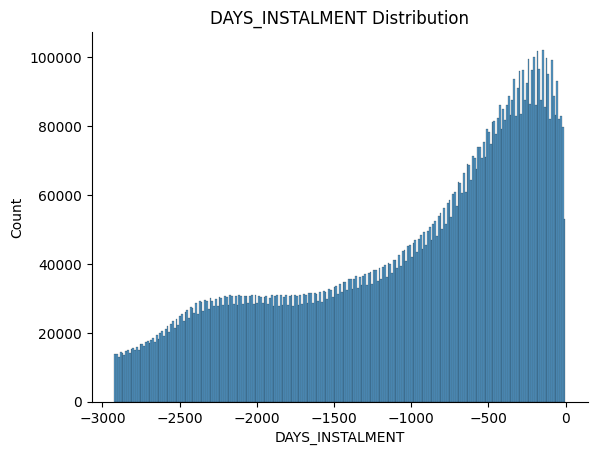

In [43]:
sns.histplot(df_inst["DAYS_INSTALMENT"])
plt.title("DAYS_INSTALMENT Distribution")
sns.despine()

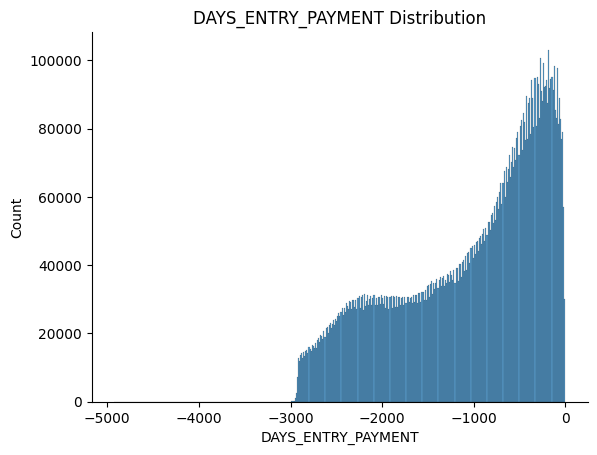

In [44]:
sns.histplot(df_inst["DAYS_ENTRY_PAYMENT"])
plt.title("DAYS_ENTRY_PAYMENT Distribution")
sns.despine()

Create an enhanced DPD feature: (days_installment - days_entry_payment) "days till deadline" feature. It would signify not only overdue, but also early payers, which could help identify good paying patterns. **NOTE FROM THE FUTURE** - this feature turned out to be one of the most promising features.

#### Amount Features

AMT features:
- AMT_INSTALMENT
- AMT_PAYMENT

They are heavily right skewed, which didn't make a great figure to look at. I have created a "Deficit" feature out of these: (AMT_INSTALMENT - AMT_PAYMENT), hoping that it would be informative similarly to DPD features. **NOTE FROM THE FUTURE** - this feature turned out to be one of the most promising features.

### Aggregate the Table

In [45]:
aggregates_inst = functions.aggregate_inst(df_inst)

In [46]:
# aggregates_inst.to_parquet("data/train/aggregates_inst.parquet")

## Aggregating df_cred Table

### Explore the Table

In essence, the credit card balance table is similar to the cash table, but has more features. I will not show exploration of all of these features. We will handle NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF the same as we did in the cash table aggregations.

#### AMT and CNT Features

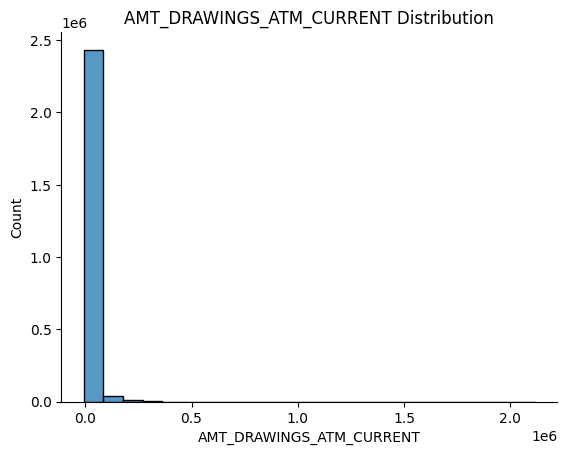

In [47]:
sns.histplot(df_cred["AMT_DRAWINGS_ATM_CURRENT"])
plt.title("AMT_DRAWINGS_ATM_CURRENT Distribution")
sns.despine()

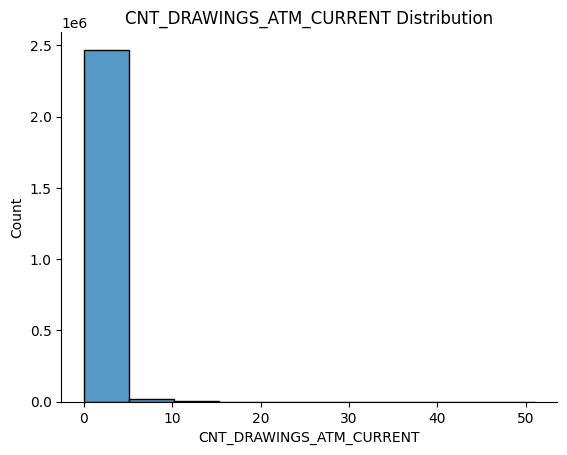

In [48]:
sns.histplot(df_cred["CNT_DRAWINGS_ATM_CURRENT"], bins=10)
plt.title("CNT_DRAWINGS_ATM_CURRENT Distribution")
sns.despine()

All AMT and CNT features have a wide range with a heavy skew.

#### DPD Features

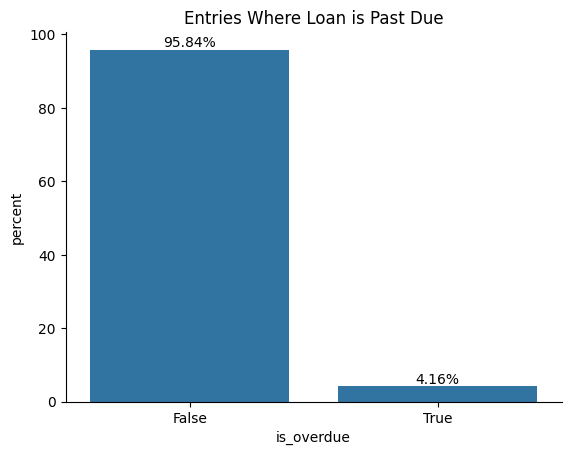

In [49]:
df_overdue = df_cred[["SK_DPD", "SK_DPD_DEF"]].copy()
df_overdue["is_overdue"] = df_overdue["SK_DPD"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue", stat="percent")
functions.add_labels(fmt="%2.2f%%")
plt.title("Entries Where Loan is Past Due")
sns.despine()

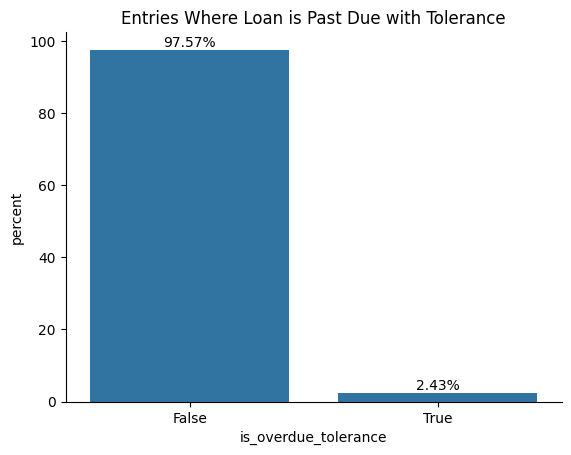

In [50]:
df_overdue["is_overdue_tolerance"] = df_overdue["SK_DPD_DEF"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue_tolerance", stat="percent")
functions.add_labels(fmt="%2.2f%%")
plt.title("Entries Where Loan is Past Due with Tolerance")
sns.despine()

Just as in the cash table, we have DPD and DPD_DEF features, which follow a similar distribution. However, we can see that we have more entries with overdue credit loans.

### Aggregate the Table

In [51]:
aggregates_cred = functions.aggregate_cred(df_cred)

In [52]:
# aggregates_cred.to_parquet("data/train/aggregates_cred.parquet")

## Aggregating df_prev_app Table

### Explore the Table

We will do a better EDA in step 4.

### Aggregate the Table

In [53]:
aggregates_prev = functions.aggregate_prev(df_prev_app)

In [54]:
# aggregates_prev.to_parquet("data/train/aggregates_prev.parquet")

## Output From This Notebook

We now have a general understanding of the features in the different tables. Also, we have generated aggregation to enrich the application table and make predicting TARGET feature easier.

IDEA for improvement: use more last statuses, especially from those tables that have monthly updates. According to this article (https://medium.com/cuenex/credit-default-prediction-practical-tips-for-successful-execution-f62a92ab5df8), "the last aggregated features are the most important features which represent the most recent statement status and are the strongest indicator of their default risk"